# Choix du modèle

Choix du modèle parmis:
* KernelRidge
* Gradient boosting
* Random Forest Regressor
* SVR???

In [17]:
import pandas as pd
import numpy as np
from meteostat import Point, Hourly
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", None)

datas = pd.read_csv("compl_datas.csv")
datas

,DateTime_m,Drive-sensor,InletTemp-sensor,Mode-sensor,SetTemp-sensor,temp,rhum,prcp,wspd,wpgt,pres
0,1.634552e+09,0.0,19.1,2.0,29.0,12.9,76.0,0.0,9.4,20.4,1022.0
1,1.634566e+09,0.0,19.3,2.0,29.0,18.6,67.0,0.0,14.8,24.1,1020.7
2,1.634580e+09,0.0,20.2,2.0,29.0,16.6,82.0,0.0,5.4,18.0,1021.3
3,1.634594e+09,0.0,20.4,2.0,29.0,15.6,93.0,0.2,11.2,24.1,1021.0
4,1.634609e+09,0.0,20.9,2.0,29.0,15.5,93.0,0.0,5.4,24.1,1020.6
...,...,...,...,...,...,...,...,...,...,...,...
5467,1.637442e+09,0.0,21.4,2.0,26.0,6.4,92.0,0.0,5.4,17.0,1020.3
5468,1.637456e+09,0.0,22.5,2.0,25.0,6.7,90.0,0.0,3.6,11.1,1017.9
5469,1.637471e+09,0.0,22.1,2.0,25.0,6.4,93.0,0.1,5.4,14.8,1016.0
5470,1.637485e+09,0.0,21.6,2.0,25.0,6.9,95.0,0.0,5.4,11.0,1015.1


In [46]:
5.5 // 6

0.0

In [18]:
scores_df = pd.DataFrame([], columns= ["kernelridge", "xgboost", "rfr"], index= ["train", "test"])
scores_df

,kernelridge,xgboost,rfr
train,NaN,NaN,NaN
test,NaN,NaN,NaN


In [19]:
from sklearn.preprocessing import QuantileTransformer, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import r2_score
from sklearn.kernel_ridge import KernelRidge
from xgboost import XGBRegressor, XGBRFRegressor


split des données

In [20]:
X_cols = [x for x in datas.columns if x not in ["SetTemp-sensor", "DateTime_m"]]
y_col = "SetTemp-sensor"

X_train, X_test, y_train, y_test = train_test_split(datas[X_cols], datas[y_col], 
    train_size= 0.7, random_state= 42)

transformation des données

In [21]:
tmp_cols = [x for x in X_train.columns if x not in ["DateTime_m", "Drive-sensor", "Mode-sensor"]]

ssc = StandardScaler()
ssc.fit(X_train[tmp_cols])

X_tr_ssc_nodate = pd.DataFrame(ssc.transform(X_train[tmp_cols]), columns= tmp_cols, index= X_train.index)
X_tr_ssc = pd.concat([X_tr_ssc_nodate, X_train[["Drive-sensor", "Mode-sensor"]]], axis= 1)

X_te_ssc_nodate = pd.DataFrame(ssc.transform(X_test[tmp_cols]), columns= tmp_cols, index= X_test.index)
X_te_ssc = pd.concat([X_te_ssc_nodate, X_test[["Drive-sensor", "Mode-sensor"]]], axis= 1)

KernelRidge

In [22]:
krr = KernelRidge(alpha= 0.01, kernel= "rbf") #, gamma= 10)

krr_model = TransformedTargetRegressor(krr, transformer=QuantileTransformer(output_distribution="uniform"))
krr_model.fit(X_tr_ssc, y_train)

y_pred = krr_model.predict(X_te_ssc)

scores_df.loc["train", "kernelridge"] = krr_model.score(X_tr_ssc, y_train)
scores_df.loc["test", "kernelridge"] = r2_score(y_test, np.round(y_pred))

Gradient boosting

In [23]:
xgb = XGBRegressor(colsample_bytree= 0.6, gamma= 0.01, max_depth= 8, min_child_weight= 1, n_estimators = 1000, 
    objective= "reg:squarederror", reg_alpha= 0.01, reg_lambda= 0.1, seed= 42, subsample = 0.9)

xgb_model = TransformedTargetRegressor(xgb, transformer=QuantileTransformer(output_distribution="uniform"))
xgb_model.fit(X_tr_ssc, y_train)

y_pred = xgb_model.predict(X_te_ssc)

scores_df.loc["train", "xgboost"] = xgb_model.score(X_tr_ssc, y_train)
scores_df.loc["test", "xgboost"] = r2_score(y_test, np.round(y_pred))

In [48]:
import joblib

joblib.dump(xgb_model, "settemp_model.sav")

['settemp_model.sav']

Random forest regressor

In [24]:
rfr = XGBRFRegressor(colsample_bynode= 0.2, max_depth= 8, min_child_weight= 5, n_estimators= 268, 
    objective= "reg:squarederror", reg_alpha= 0.01, reg_lambda= 0.001, seed= 42, subsample= 0.9)

rfr_model = TransformedTargetRegressor(rfr, transformer=QuantileTransformer(output_distribution="uniform"))
rfr_model.fit(X_tr_ssc, y_train)

y_pred = rfr_model.predict(X_te_ssc)

scores_df.loc["train", "rfr"] = rfr_model.score(X_tr_ssc, y_train)
scores_df.loc["test", "rfr"] = r2_score(y_test, np.round(y_pred))

Graph des scores

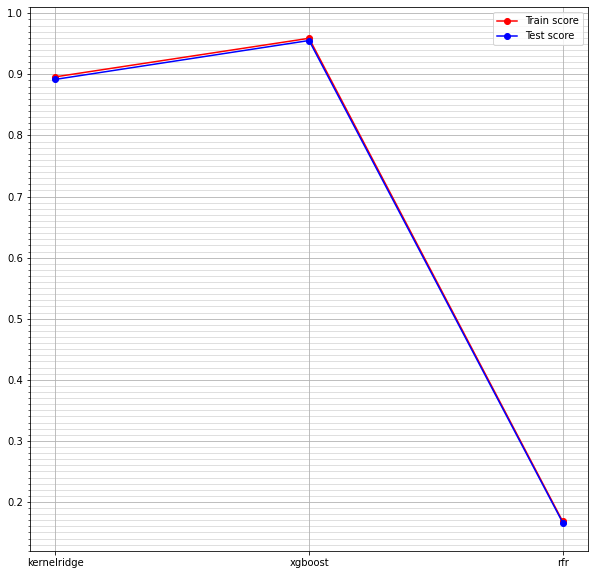

In [25]:
fig, ax = plt.subplots(figsize=(10,10))

ax.plot([x for x in scores_df.columns], [scores_df.loc["train", x] for x in scores_df.columns], "ro-", label= "Train score")
ax.plot([x for x in scores_df.columns], [scores_df.loc["test", x] for x in scores_df.columns], "bo-", label= "Test score")

ymin = round(scores_df.min().min()-0.05, 2)
ymax = round(scores_df.max().max()+0.05, 2)
plt.ylim(ymin, ymax)
ax.set_yticks(np.linspace(ymin, ymax, int((ymax-ymin)*100+1)), minor=True)

ax.grid(True, which="major" , axis="y", alpha= 1)
ax.grid(True, which="minor" , axis="y", alpha= 0.5)
ax.grid(True, which="major" , axis="x")

ax.legend()
plt.show()

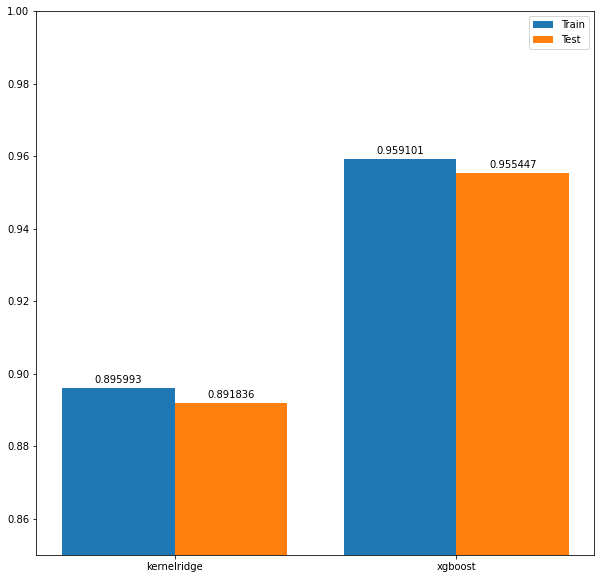

In [26]:
labels = ["kernelridge", "xgboost"]
train_scores = [scores_df.loc["train", x] for x in labels]
test_scores = [scores_df.loc["test", x] for x in labels]

x = np.arange(len(labels))
width = 0.4

fig, ax = plt.subplots(figsize=(10, 10))
rects1 = ax.bar(x - width/2, train_scores, width, label= "Train")
rects2 = ax.bar(x + width/2, test_scores, width, label= "Test")

ax.set_xticks(x)
ax.set_xticklabels(labels)

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

plt.ylim(0.85, 1.0)

ax.legend()
plt.show()

XGBRegressor est le meilleur modèle

   temp  dwpt  rhum  prcp  snow   wdir  wspd  wpgt    pres  tsun  coco
0   8.3   7.5  95.0   0.0   NaN  202.0  10.4  16.7  1004.3   NaN   7.0
   temp  dwpt  rhum  prcp  snow   wdir  wspd  wpgt    pres  tsun  coco
0   8.3   7.5  95.0   0.0   NaN  202.0  10.4  16.7  1004.3   NaN   7.0
   temp  dwpt  rhum  prcp  snow   wdir  wspd  wpgt    pres  tsun  coco
0   8.3   7.5  95.0   0.0   NaN  202.0  10.4  16.7  1004.3   NaN   7.0
   temp  dwpt  rhum  prcp  snow   wdir  wspd  wpgt    pres  tsun  coco
0   8.3   7.5  95.0   0.0   NaN  202.0  10.4  16.7  1004.3   NaN   7.0
   temp  dwpt  rhum  prcp  snow   wdir  wspd  wpgt    pres  tsun  coco
0   8.3   7.5  95.0   0.0   NaN  202.0  10.4  16.7  1004.3   NaN   7.0
   temp  dwpt  rhum  prcp  snow   wdir  wspd  wpgt    pres  tsun  coco
0   8.3   7.5  95.0   0.0   NaN  202.0  10.4  16.7  1004.3   NaN   7.0
   temp  dwpt  rhum  prcp  snow   wdir  wspd  wpgt    pres  tsun  coco
0   8.3   7.5  95.0   0.0   NaN  202.0  10.4  16.7  1004.3   NaN   7.0
   tem

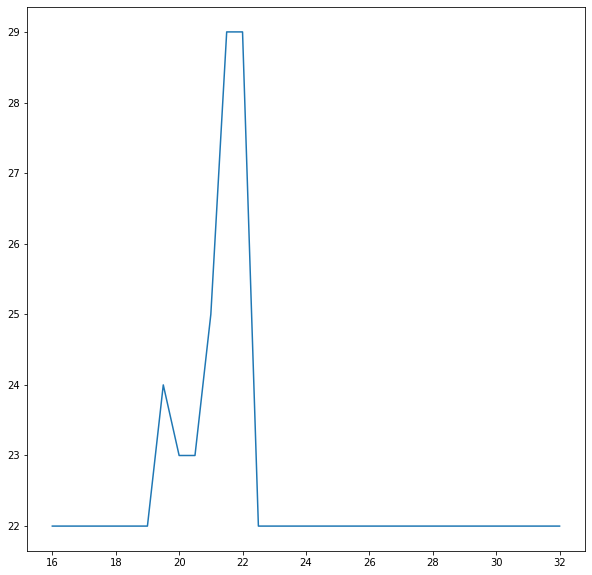

In [56]:
from datetime import datetime, timedelta

model = joblib.load("settemp_model.sav")

datetime_m = datetime.timestamp(datetime.now())
# Ville
Paris = Point(48.82, 2.34, 75)

results_list = []
for i in np.arange(16, 32.1, 0.5):
    drive = 0.0
    inlet = i
    mode = 2.0

    m_datas = Hourly(Paris, datetime.now() - timedelta(hours= 1), datetime.now())
    m_datas = m_datas.fetch()
    m_datas = m_datas.reset_index(drop= True)
    print(m_datas)

    temp = m_datas.loc[0, "temp"]
    rhum = m_datas.loc[0, "rhum"]
    prcp = m_datas.loc[0, "prcp"]
    wspd = m_datas.loc[0, "wspd"]
    wpgt = m_datas.loc[0, "wpgt"]
    pres = m_datas.loc[0, "pres"]

    df_test = pd.DataFrame([[inlet, 25, rhum, prcp, wspd, wpgt, pres, drive, mode]], 
        columns= X_tr_ssc.columns)
    # print(df_test)

    df_tmp = pd.DataFrame(ssc.transform(df_test[tmp_cols]), columns= tmp_cols)
    df_test = pd.concat([df_tmp, df_test[["Drive-sensor", "Mode-sensor"]]], axis= 1)


    # print(f"df_test {i}: {krr.predict(df_test)}")
    results_list.append(np.round(model.predict(df_test)))

fig = plt.figure(figsize=(10, 10))

plt.plot([x for x in np.arange(16, 32.1, 0.5)], results_list)
